**This notebook is an exercise in the [Machine Learning Explainability](https://www.kaggle.com/learn/machine-learning-explainability) course.  You can reference the tutorial at [this link](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values).**

---


## Set Up


We have again provided code to do the basic loading, review and model-building. Run the cell below to set everything up:

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import shap

# Environment Set-Up for feedback system.
from learntools.core import binder
binder.bind(globals())
from learntools.ml_explainability.ex5 import *
print("Setup Complete")


import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

data = pd.read_csv('../input/hospital-readmissions/train.csv')
y = data.readmitted
base_features = ['number_inpatient', 'num_medications', 'number_diagnoses', 'num_lab_procedures', 
                 'num_procedures', 'time_in_hospital', 'number_outpatient', 'number_emergency', 
                 'gender_Female', 'payer_code_?', 'medical_specialty_?', 'diag_1_428', 'diag_1_414', 
                 'diabetesMed_Yes', 'A1Cresult_None']

# Some versions of shap package error when mixing bools and numerics
X = data[base_features].astype(float)

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

# For speed, we will calculate shap values on smaller subset of the validation data
small_val_X = val_X.iloc[:150]
my_model = RandomForestClassifier(n_estimators=30, random_state=1).fit(train_X, train_y)

Setup Complete


In [2]:
data.describe()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmitted
count,25000.000000,25000.00000,25000.000000,25000.000000,25000.000000,25000.000000,25000.00000,25000.000000,25000.000000
mean,4.395640,42.96012,1.341080,15.988440,0.365920,0.203280,0.64300,7.420160,0.456400
std,2.991165,19.76881,1.705398,8.107743,1.224419,0.982973,1.26286,1.940932,0.498105
min,1.000000,1.00000,0.000000,1.000000,0.000000,0.000000,0.00000,1.000000,0.000000
25%,2.000000,31.00000,0.000000,10.000000,0.000000,0.000000,0.00000,6.000000,0.000000
50%,4.000000,44.00000,1.000000,15.000000,0.000000,0.000000,0.00000,8.000000,0.000000
75%,6.000000,57.00000,2.000000,20.000000,0.000000,0.000000,1.00000,9.000000,1.000000
max,14.000000,126.00000,6.000000,81.000000,36.000000,64.000000,21.00000,16.000000,1.000000


The first few questions require examining the distribution of effects for each feature, rather than just an average effect for each feature.  Run the following cell for a summary plot of the shap_values for readmission. It will take about 20 seconds to run.

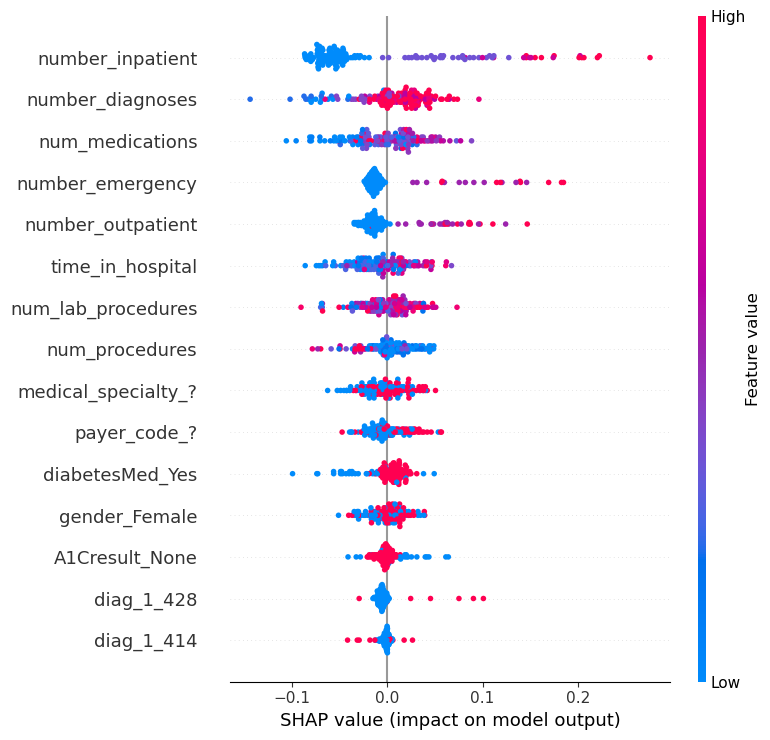

In [3]:
explainer = shap.TreeExplainer(my_model)
shap_values = explainer.shap_values(small_val_X)

shap.summary_plot(shap_values[1], small_val_X)

## Question 1

Which of the following features has a bigger range of effects on predictions (i.e. larger difference between most positive and most negative effect)
- `diag_1_428` or
- `payer_code_?`

In [10]:
# the range of diag_1_428 is wider, largely due to the few points on the far right.
feature_with_bigger_range_of_effects = 'diag_1_428'

# Check your answer
q_1.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct</span>

Uncomment the line below to see the solution and explanation.

## Question 2

Do you believe the range of effects sizes (distance between smallest effect and largest effect) is a good indication of which feature will have a higher permutation importance? Why or why not?  

If the **range of effect sizes** measures something different from **permutation importance**: which is a better answer for the question "Which of these two features does the model say is more important for us to understand when discussing readmission risks in the population?"

Run the following line after you've decided your answer.

In [11]:
# Check your answer (Run this code cell to receive credit!)
q_2.solution()

<IPython.core.display.Javascript object>

<span style="color:#33cc99">Solution:</span> 
No. The width of the effects range is not a reasonable approximation to permutation importance. For that matter, the width of the range doesn't map well to any intuitive sense of "importance" because it can be determined by just a few outliers.
However if all dots on the graph are widely spread from each other, that is a reasonable indication that permutation importance is high.
Because the range of effects is so sensitive to outliers, permutation importance is a better measure of what's generally important to the model.


## Question 3

Both `diag_1_428` and `payer_code_?` are binary variables, taking values of 0 or 1.

From the graph, which do you think would typically have a bigger impact on predicted readmission risk:
- Changing `diag_1_428` from 0 to 1
- Changing `payer_code_?` from 0 to 1

To save you scrolling, we have included a cell below to plot the graph again (this one runs quickly).

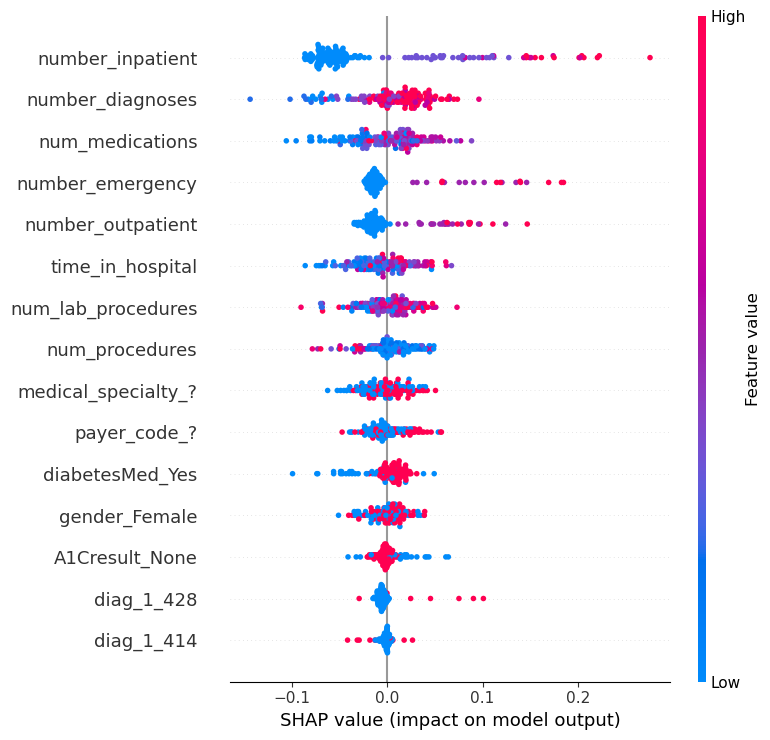

In [13]:
shap.summary_plot(shap_values[1], small_val_X)

In [16]:
# Set following var to "diag_1_428" if changing it to 1 has bigger effect.  Else set it to 'payer_code_?'
bigger_effect_when_changed = 'diag_1_428'

# Check your answer
q_3.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct:</span> 


While most SHAP values of diag_1_428 are small, the few pink dots (high values of the variable, corresponding to people with that diagnosis) have large SHAP values.  In other words, the pink dots for this variable are far from 0, and making someone have the higher (pink) value would increase their readmission risk significantly.
In real-world terms, this diagnosis is rare, but poses a larger risk for people who have it.
In contrast, `payer_code_?` has many values of both blue and pink, and both have SHAP values that differ meaningfully from 0.
But changing `payer_code_?` from 0 (blue) to 1 (pink) is likely to have a smaller impact than changing `diag_1_428`.


## Question 4

Some features (like `number_inpatient`) have reasonably clear separation between the blue and pink dots. Other variables like `num_lab_procedures` have blue and pink dots jumbled together, even though the SHAP values (or impacts on prediction) aren't all 0.

What do you think you learn from the fact that `num_lab_procedures` has blue and pink dots jumbled together? Once you have your answer, run the line below to verify your solution.

In [18]:
# Check your answer (Run this code cell to receive credit!)
q_4.solution()

<IPython.core.display.Javascript object>

<span style="color:#33cc99">Solution:</span> 
The jumbling suggests that sometimes increasing that feature leads to higher predictions, and other times it leads to a lower prediction. Said another way, both high and low values of the feature can have both positive and negative effects on the prediction.
The most likely explanation for this "jumbling" of effects is that the variable (in this case `num_lab_procedures`) has an interaction effect with other variables.  For example, there may be some diagnoses for which it is good to have many lab procedures, and other diagnoses where suggests increased risk. We don't yet know what other feature is interacting with `num_lab_procedures` though we could investigate that with SHAP contribution dependence plots.


## Question 5

Consider the following SHAP contribution dependence plot. 

The x-axis shows `feature_of_interest` and the points are colored based on `other_feature`.

![Imgur](https://i.imgur.com/zFdHneM.png)

Is there an interaction between `feature_of_interest` and `other_feature`?  
If so, does `feature_of_interest` have a more positive impact on predictions when `other_feature` is high or when `other_feature` is low?

Run the following code when you are ready for the answer.

In [19]:
# Check your answer (Run this code cell to receive credit!)
q_5.solution()

<IPython.core.display.Javascript object>

<span style="color:#33cc99">Solution:</span> 
First, recall that the SHAP vaue is an estimate of the impact of a given feature on the prediction. So, if the dots trend from upper left to lower right, that means low values of `feature_of_interest` cause higher predictions.

Returning to this graph:

`feature_of_interest` slopes downward for high values of `other_feature`. To see this, focus your eye on the pink dots (where `other_feature` is high) and imagine a best-fit line through those pink dots.  It slopes down, suggesting that the prediction goes down as `feature_of_interest` increases.

Now focus your eye on the blue dots, and imagine a best fit line through those dots.  It is generally pretty flat, possibly even curving up on the right side of the graph. So increasing `feature_of_interest` has a more positive impact on predictions when `other_feature` is high.


## Question 6

Review the summary plot for the readmission data by running the following cell:

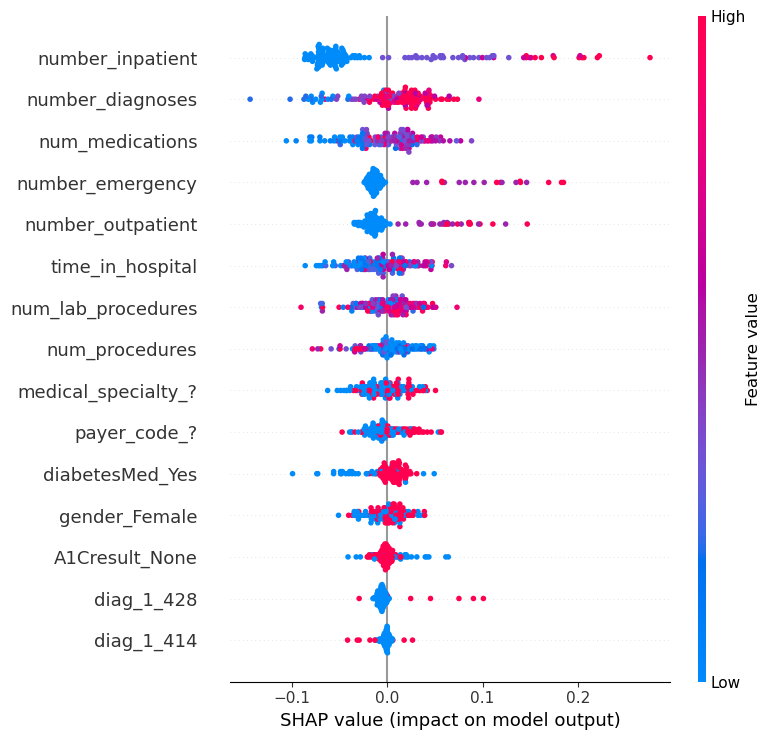

In [20]:
shap.summary_plot(shap_values[1], small_val_X)

Both **num_medications** and **num_lab_procedures** share that jumbling of pink and blue dots.

Aside from `num_medications` having effects of greater magnitude (both more positive and more negative), it's hard to see a meaningful difference between how these two features affect readmission risk.  Create the SHAP dependence contribution plots for each variable, and describe what you think is different between how these two variables affect predictions.

As a reminder, here is the code you previously saw to create this type of plot.

    shap.dependence_plot(feature_of_interest, shap_values[1], val_X)
    
And recall that your validation data is called `small_val_X`.

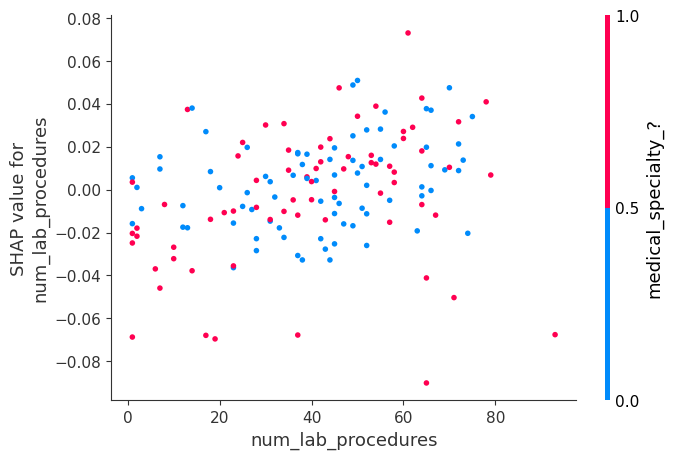

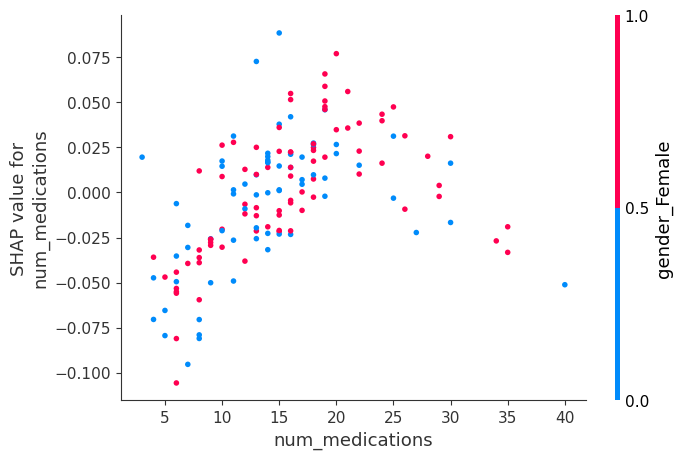

In [22]:
shap.dependence_plot('num_lab_procedures', shap_values[1], small_val_X)
shap.dependence_plot('num_medications', shap_values[1], small_val_X)

Then run the following line to compare your observations from this graph to the solution.

In [21]:
# Check your answer (Run this code cell to receive credit!)
q_6.solution()

<IPython.core.display.Javascript object>

<span style="color:#33cc99">Solution:</span> 
Here is the code:

    shap.dependence_plot('num_lab_procedures', shap_values[1], small_val_X)
    shap.dependence_plot('num_medications', shap_values[1], small_val_X)

.
Loosely speaking, **num_lab_procedures** looks like a cloud with little disernible pattern.  It does not slope steeply up nor down at any point. It's hard to say we've learned much from that plot. At the same time, the values are not all very close to 0. So the model seems to think this is a relevant feature. One potential next step would be to explore more by coloring it with different other features to search for an interaction.

On the other hand, **num_medications** clearly slopes up until a value of about 20, and then it turns back down. Without more medical background, this seems a surprising phenomenon... You could do some exploration to see whether these patients have unusual values for other features too. But a good next step would be to discuss this phenomenon with domain experts (in this case, the doctors).


## Congratulations

That's it!  Machine learning models should not feel like black boxes any more, because you have the tools to inspect them and understand what they learn about the world. 

This is an excellent skill for debugging models, building trust, and learning insights to make better decisions. These techniques have revolutionized how I do data science, and I hope they do the same for you.

Real data science involves an element of exploration. I hope you find an interesting dataset to try these techniques on (Kaggle has a lot of [free datasets](https://www.kaggle.com/datasets) to try out). If you learn something interesting about the world, share your work [in this forum](https://www.kaggle.com/learn-forum/66354). I'm excited to see what you do with your new skills.

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/machine-learning-explainability/discussion) to chat with other learners.*